# Exibição de informações dos parlamentares

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import csv
import squarify 

import os

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity="all"

## Carga de infos básicas. 

In [2]:
#!ls ../dados/tse/ibge

## Carga de parlamentares

In [3]:
#Dados de parlamentares
df_parlamentares=pd.read_csv("../dados/tse/detalhes_parlamentares.csv", 
                             encoding="ISO-8859-1",
                             header=0)

In [4]:
df_parlamentares=df_parlamentares.rename(columns={"NR_CPF_CANDIDATO":"CPF"})

In [5]:
df_parlamentares.columns
#df_parlamentares.head()
#df_parlamentares.shape
df_parlamentares.info()

Index(['Unnamed: 0', 'ANO_ELEICAO', 'SG_UE', 'DS_CARGO', 'SQ_CANDIDATO',
       'NM_CANDIDATO', 'NM_URNA_CANDIDATO', 'CPF', 'NM_EMAIL', 'SG_PARTIDO',
       'SG_UF_NASCIMENTO', 'NM_MUNICIPIO_NASCIMENTO', 'DT_NASCIMENTO',
       'NR_IDADE_DATA_POSSE', 'DS_GENERO', 'DS_GRAU_INSTRUCAO',
       'DS_ESTADO_CIVIL', 'DS_COR_RACA', 'DS_OCUPACAO', 'DS_SIT_TOT_TURNO',
       'ST_REELEICAO', 'ST_DECLARAR_BENS', 'CD_TIPO_BEM_CANDIDATO',
       'DS_TIPO_BEM_CANDIDATO', 'DS_BEM_CANDIDATO', 'VR_BEM_CANDIDATO'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               6745 non-null   int64  
 1   ANO_ELEICAO              6745 non-null   int64  
 2   SG_UE                    6745 non-null   object 
 3   DS_CARGO                 6745 non-null   object 
 4   SQ_CANDIDATO             6745 non-null   int64  
 5   NM_CANDIDATO             6745 non-null   object 
 6   NM_URNA_CANDIDATO        6745 non-null   object 
 7   CPF                      6745 non-null   int64  
 8   NM_EMAIL                 6745 non-null   object 
 9   SG_PARTIDO               6745 non-null   object 
 10  SG_UF_NASCIMENTO         6745 non-null   object 
 11  NM_MUNICIPIO_NASCIMENTO  6745 non-null   object 
 12  DT_NASCIMENTO            6745 non-null   object 
 13  NR_IDADE_DATA_POSSE      6745 non-null   float64
 14  DS_GENERO               

## Carga de municipios e votação

In [6]:
#Dados de municípios
df_municipios=pd.read_csv("../dados/tse/detalhes_municipios.csv", encoding="ISO-8859-1",header=0)


/home/carlos/anaconda3/envs/R/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
#df_municipios.columns[18]
#df_municipios.head()
#f_municipios.shape

In [8]:
#df_municipios.columns[18]

In [9]:
df_municipios.drop(columns=["Unnamed: 0","RESULTADO_2018","RESULTADO_2014",
                            "DS_DETALHE_SITUACAO_CAND"], inplace=True)


In [10]:
#df_municipios.info()
#df_municipios.head()

## Consolidação de informações de votação

In [11]:
df_cpfs=df_parlamentares[["CPF","SQ_CANDIDATO"]]
df_cpfs=df_cpfs.drop_duplicates(keep="first")


In [12]:
df_municipios_votacao=pd.merge(df_municipios,df_cpfs, how="left", on="SQ_CANDIDATO")
#df_municipios_votacao.head()


In [13]:
#df_municipios_votacao.info()

## Carga de informações geograficas dos municípios

In [14]:
lista_uf=list(df_municipios_votacao["SG_UF"].unique())
df_mapa_brasil=pd.DataFrame()

In [15]:
for uf in lista_uf:
    diretorio="../dados/ibge/shapes/"+uf
    arquivos=os.listdir(diretorio)
    shapefile = [arq for arq in arquivos if ".shp" in arq][0]
    arq=diretorio+"/"+shapefile
    df_uf= gpd.read_file(arq)
    df_uf["SG_UF"]=uf
    df_mapa_brasil=pd.concat([df_mapa_brasil,df_uf])
    

In [16]:
#df_mapa_brasil.info()

In [17]:
df_mapa_brasil=df_mapa_brasil.astype({"CD_GEOCODM":"float64"})
df_mapa_brasil.rename(columns={"CD_GEOCODM":"CODIGO_IBGE"}, inplace=True)
#df_mapa_brasil.info()

In [18]:
#df_mapa_brasil.head()
#df_mapa_brasil.to_csv("../dados/ibge/mapa_brasil.csv")

# Funções de exibição

In [19]:
# Plot estado e municipios com indicador
def plot_estado(estado,indicador,titulo, minimo,maximo, cor):
    vmin=minimo
    vmax=maximo
    fig, ax = plt.subplots(figsize=(12,8))
    estado.plot(ax=ax, column=indicador, cmap=cor, edgecolor="black", linewidth=0.2)
    sm = plt.cm.ScalarMappable(cmap=cor, norm=plt.Normalize(vmin=vmax, vmax=vmin))
    sm._A = []
    cbar = fig.colorbar(sm)
    plt.title(titulo, fontsize=40, color="grey")
    ax.axis('off')
    plt.axis("equal")
    plt.show()
    return

In [20]:
def exibe_cadastro(cpf):
    df_parlamentar=df_parlamentares[df_parlamentares["CPF"]==cpf]
    valor_bens=df_parlamentar["VR_BEM_CANDIDATO"].sum()
    campos=["NM_URNA_CANDIDATO","NM_CANDIDATO","DT_NASCIMENTO","DS_COR_RACA",
            "DS_GRAU_INSTRUCAO","DS_OCUPACAO"]
    parlamentar=df_parlamentar[campos].drop_duplicates(keep="first").to_dict(orient="records")[0]
    parlamentar["BENS"]=valor_bens.round(2)
    print(parlamentar)
    return


In [21]:
def exibe_votacao_estado(cpf, cpf_votacao):
    uf=cpf_votacao["SG_UF"].iloc[0]
    nome=cpf["NM_URNA_CANDIDATO"].iloc[0]
    cpf_municipios=df_mapa_brasil[df_mapa_brasil["SG_UF"]==uf]
    cpf_municipios=pd.merge(cpf_municipios,cpf_votacao, how="left", on="CODIGO_IBGE")
    cpf_municipios=cpf_municipios.sort_values('QT_VOTOS_NOMINAIS', ascending=False)
    indicador=indicador="IDHM_2010"
    titulo=uf+" - "+"IDHM Municípios"
    minimo=0
    maximo=1
    cor="RdBu"
    plot_estado(cpf_municipios, indicador, titulo, minimo ,maximo, cor)
    indicador="QT_VOTOS_NOMINAIS"
    titulo=nome+" - "+"Votos por município"
    minimo=0
    maximo=cpf_municipios[indicador].max()
    cor="Blues"
    plot_estado(cpf_municipios, indicador, titulo, minimo ,maximo, cor)
    plt.figure(figsize=(12,8))
    squarify.plot(sizes=cpf_municipios['QT_VOTOS_NOMINAIS'][1:15], label=cpf_municipios['NM_MUNICIPIO'][1:15], alpha=.8 )
    return

# Escolhe randomicamente um CPF e chama as funções

4862780857

{'NM_URNA_CANDIDATO': 'CORONEL TADEU', 'NM_CANDIDATO': 'MARCIO TADEU ANHAIA DE LEMOS', 'DT_NASCIMENTO': '30/09/1965', 'DS_COR_RACA': 'BRANCA', 'DS_GRAU_INSTRUCAO': 'ENSINO FUNDAMENTAL COMPLETO', 'DS_OCUPACAO': 'OUTROS', 'BENS': 932000.0}


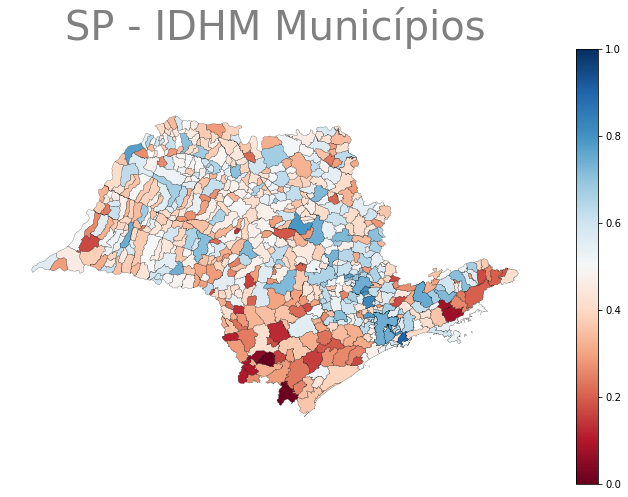

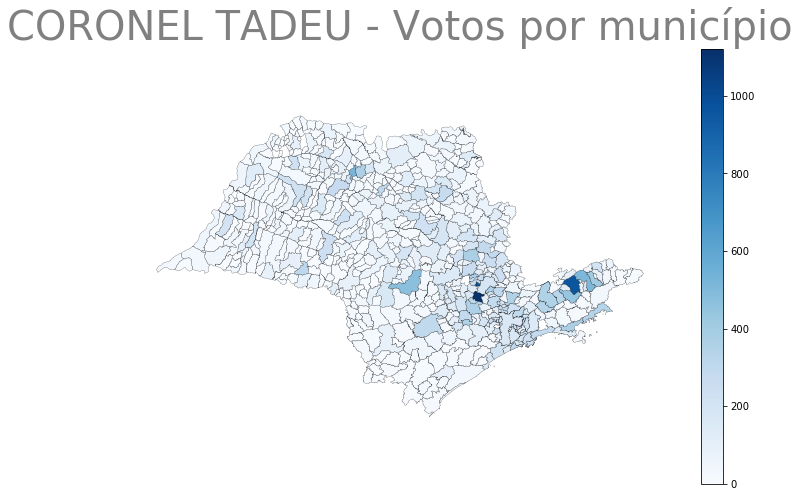

/home/carlos/anaconda3/envs/R/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/carlos/anaconda3/envs/R/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/carlos/anaconda3/envs/R/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 130 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/carlos/anaconda3/envs/R/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 130 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/carlos/anaconda3/envs/R/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/carlos/anaconda3/envs/R/lib/python3.7/site-packages/matplo

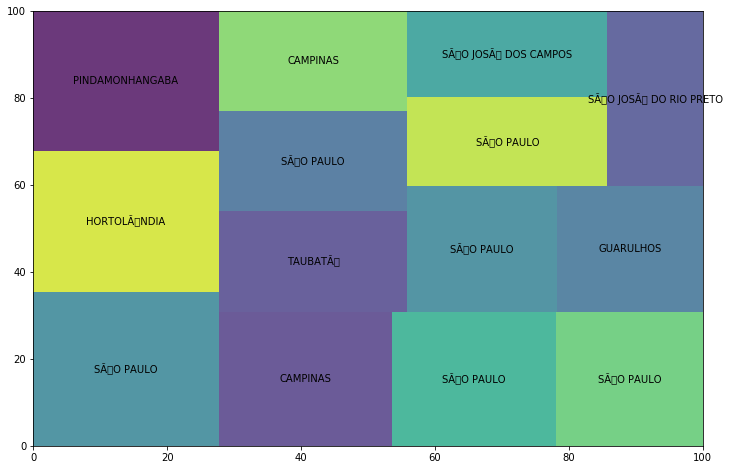

In [22]:
cpf=df_cpfs["CPF"].sample(n=1).iloc[0]
cpf
df_cpf_votacao=df_municipios_votacao[df_municipios_votacao["CPF"]==cpf]
df_cpf=df_parlamentares[df_parlamentares["CPF"]==cpf]
exibe_cadastro(cpf)
exibe_votacao_estado(df_cpf, df_cpf_votacao)

In [23]:
df_parlamentares.columns

Index(['Unnamed: 0', 'ANO_ELEICAO', 'SG_UE', 'DS_CARGO', 'SQ_CANDIDATO',
       'NM_CANDIDATO', 'NM_URNA_CANDIDATO', 'CPF', 'NM_EMAIL', 'SG_PARTIDO',
       'SG_UF_NASCIMENTO', 'NM_MUNICIPIO_NASCIMENTO', 'DT_NASCIMENTO',
       'NR_IDADE_DATA_POSSE', 'DS_GENERO', 'DS_GRAU_INSTRUCAO',
       'DS_ESTADO_CIVIL', 'DS_COR_RACA', 'DS_OCUPACAO', 'DS_SIT_TOT_TURNO',
       'ST_REELEICAO', 'ST_DECLARAR_BENS', 'CD_TIPO_BEM_CANDIDATO',
       'DS_TIPO_BEM_CANDIDATO', 'DS_BEM_CANDIDATO', 'VR_BEM_CANDIDATO'],
      dtype='object')

In [24]:
df_cpf_municipios.columns
df_municipios=df_cpf_municipios.sort_values("NM_MUNICIPIO").head()
df_cpf_municipios.shape

NameError: name 'df_cpf_municipios' is not defined

In [ ]:
df_cpf_votacao=df_cpf_municipios[["NM_MUNICIP","QT_VOTOS_NOMINAIS"]].sort_values("QT_VOTOS_NOMINAIS", 
                                                                                 ascending=False)

In [ ]:
df_cpf_votacao.head(10)
df_cpf_votacao.shape

In [ ]:
total=df_cpf_votacao["QT_VOTOS_NOMINAIS"].sum()
df_cpf_votacao["PERCENT"]=df_cpf_votacao["QT_VOTOS_NOMINAIS"]/total

In [ ]:
df_cpf_votacao.head()
df_cpf_votacao.shape
total

In [ ]:
import streamlit as st

In [ ]:
# libraries
import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)
 
# If you have 2 lists
squarify.plot(sizes=[13,22,35,5], label=["group A", "group B", "group C", "group D"], alpha=.7 )
plt.axis('off')
plt.show()
 
# If you have a data frame?
import pandas as pd
df = pd.DataFrame({'nb_people':[8,3,4,2], 'group':["group A", "group B", "group C", "group D"] })
squarify.plot(sizes=df['nb_people'], label=df['MUNICIPIO'], alpha=.8 )
plt.axis('off')
plt.show() 

In [ ]:
#libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import squarify # pip install squarify (algorithm for treemap)&lt;/pre&gt;
 
# Create a dataset:
my_values=[i**3 for i in range(1,100)]
 
# create a color palette, mapped to these values
cmap = matplotlib.cm.Blues
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
 
# Change color
squarify.plot(sizes=my_values, alpha=.8, color=colors )
plt.axis('off')
plt.show()